#Slot Prediction for Localities
The choice of delivery time slots has to balance marketing and  operational considerations  resulting in cost savings for the organization. Identifying specific time slots for each localities when there is higher chance of success is key to success. Also, if there is any distinction can be made between residential and commercial localities

In [12]:
#Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import generic_utils
import config
import pandas as pd
import config
import generic_utils
import re
import nltk
import gensim
from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.manifold import TSNE
from sklearn.manifold import TSNE

In [206]:
#Reading the Locality Data for last 3 months

#Date Range - 23rd Oct to 24th Jan 2019

timeSlotData= pd.read_csv("clustering_data.csv")




In [207]:
# Filtering for only the address column 

addressField = timeSlotData[["combined_address"]]

In [4]:
addressField.head()

path_to_csv='/data/Projects/Amir/alias_size_1.csv'

In [5]:


alias_size_1= pd.read_csv('alias_size_1.csv')
alias_size_2= pd.read_csv('alias_size_2.csv')
alias_size_3= pd.read_csv('alias_size_3.csv')
phrase_alias = pd.read_csv("phrase_alias")

In [15]:
def segregate_joint_alphabet_numerics(address):
        """Given an address, if there exist any word having alphabets and 
        numerics consecutively without any space, put a space between 
        alphabet and numeric part with the exception of cases like '1st', 
        '2nd' etc.

        :param str address: Given address in which alphabet and numerics are 
                to be segregated

        :returns: Adress after segregation of alphabet and numeric part

        """
        splitted_address = address.split(',')
        replaced_address = []
        for phrase in splitted_address:
            words = phrase.split()
            for i, word in enumerate(words):
                # if a word contains both alphabet and numerics, then the two
                # parts are separated with the exceptions of words like
                # '1st', '2nd', '6th' etc. Regular Expression
                # r"[a-z(),]+|[\d(),]+" helps separate the two parts
                if not re.match(r"^[0-9]+(st|nd|rd|th)$", word):
                    words[i] = " ".join(re.findall(r"[a-z()]+|[\d()]+", word))
            replaced_address.append(" ".join(words))
        return ",".join(replaced_address)


In [17]:
 def align_numeric_part(address):
        """Sector 6 is sometimes written as 6th Sector and similar trend 
        follows for the case of phase, block, pocket etc. as well. This 
        function transforms from the convetion of 'nth entity' to 'entity n' 
        i.e. '2nd block' to 'block 2' etc.

        :param str address: Address in which numeric part is to be aligned.

        """
        pattern = (r"([0-9]+)(st|nd|rd|th)(\s+)(sector|phase|block|pocket|"
                   r"street|building)(?=[^a-z]|$)")
        matches = re.findall(pattern, address)
        for match in matches:
            address = address.replace(
                ''.join(match), ' ' + match[3] + ' ' + match[0])
        return address


In [6]:
def replace_alias(address):
        """Hard coded alias are stored for some commonly occurring incorrect 
        spellings people wirite, for ex. bldg -> building, rd no -> road 
        number etc. Given an address, if there are any incorrect spelling 
        present in the address this function replaces them with their correct 
        alias.

        Higher length incorrect spellings are replaced first and then the 
        lower length incorrect spellings are replcaed. For example we first 
        replace length 3 incorrect spellings, then length 2 and then length 1.

        :param str address: Given address whose incorrect spellings are to be 
                replaced

        :returns: Refined address with incorrect spellings replaced with 
                corresponding aliases

        """
        splitted_address = address.split(',')
        replaced_address = []
        for phrase in splitted_address:
            words = phrase.split()
            num_word = len(words)
            # FIXME: Need to make the algorithm efficient using Trie structure
            for j, word in enumerate(words):
                size_3_replaced = False
                size_2_replaced = False
                # If starting from this word length 3 size incorrect spelling
                # exist then replace it with correspondig alias, else look
                # for length 2 incorrect spelling and then length 1 incorrect
                # spelling
                if j + 2 < num_word:
                    new_word = alias_size_3.get(
                        word + " " + words[j + 1] + " " + words[j + 2])
                    if new_word is not None:
                        words[j] = new_word
                        del words[j + 2]
                        del words[j + 1]
                        num_word = len(words)
                        size_3_replaced = True
                if not size_3_replaced:
                    if j + 1 < num_word:
                        new_word = alias_size_2.get(
                            word + " " + words[j + 1])
                        if new_word is not None:
                            words[j] = new_word
                            del words[j + 1]
                            num_word = len(words)
                            size_2_replaced = True
                    if not size_2_replaced:
                        words[j] = alias_size_1.get(word, word)
            replaced_phrase = " ".join(words)
            if replaced_phrase and not replaced_phrase.isspace():
                replaced_phrase = " ".join(replaced_phrase.split())
                replaced_address.append(replaced_phrase)
        return ",".join(replaced_address)


In [7]:
def _clean_at_phrase_level(address):
        """Clean the address at comma separated phrase level.

        :param str address: Address to be cleaned at phrase level.

        """
        splitted_address = address.split(',')
        address_array = []
        for phrase in splitted_address:
            if (phrase and not phrase.isspace()):
                phrase = " ".join(phrase.split())
                clean_phrase = phrase_alias.get(phrase, phrase)
                numeric_match = re.match(
                    r"^([0-9]+)\s?(st|nd|rd|th)$", clean_phrase)
                if numeric_match:
                    clean_phrase = numeric_match.group(1)
                    pattern = (r"^(([0-9]+|[a-z]{1,2}) floor|"
                            r"floor( (no|num|number))? ([0-9]+(st|nd|rd|th)?|"
                            r"[a-z]{1,2}))$")
                    floor_match = re.match(pattern, clean_phrase)
                    clean_phrase = '' if floor_match else clean_phrase
                if clean_phrase:
                    address_array.append(clean_phrase)
        seen = set()
        seen_add = seen.add
        address_array_unique = [x for x in reversed(
            address_array) if not (x in seen or seen_add(x))]
        address_array_unique = list(reversed(address_array_unique))
        return ",".join(address_array_unique)


In [8]:
city='Gurugram'
state='Haryana'

def clean_city_and_state(city, state):
        """Clean the city and state.

        :param str city: City
        :param str state: State

        :returns: City & State after cleaning

        """
        city_and_state = city + state
        if city_and_state.count('/') == 1:
            city, state = city_and_state.split('/')
        city = clean_address_new(city)
        state = clean_address_new(state)
        # Many time merchant writes 'in-' before state name. i.e. in-punjab
        if state.startswith('in '):
            state = state[3:]
        state = self.state_abbreviations.get(state, state)
        return city, state



In [9]:
 def remove_intermediate_city_state_pincode(address_data):
        """Given the address data, if city/state field is non-empty then 
        remove the city/state name from in-between the address. City/state 
        can be appended at the end of address later on whenever needed. This
        function removes the pincode from the address.


        """
        address = address_data['address']
        city = address_data['city']
        state = address_data['state']
        pincode = address_data['pincode']
        modified_phrases = []
        # if pincode is present in both address field and pincode field,
        # update with the rightmost one present in address field.
        pincode_match = re.findall(r"\b([0-9]{6})\b", address)
        pincode_in_add = pincode_match[-1] if pincode_match else None
        pin = pincode_in_add if pincode_in_add else pincode
        address_data['pincode'] = pin
        all_pincodes_set = set([pincode])
        if pincode_match:
            all_pincodes_set |= set(pincode_match)
        for phrase in address.split(','):
            # Keep all phrases of address other than pincode, city and state
            # FIXME: Check if using levenshtein distance below can be harmful
            # and should be removed OR should it be replaced with fuzzy
            # FIXME: chack if combination of city & state (i.e. 'gurgaon
            # haryana') should also be removed
            if not ((phrase in all_pincodes_set) or
                    (city and l_distance(phrase, city) < 2) or
                    (state and l_distance(phrase, state) < 2)):
                # Note that pincode/city/state are removed only if they
                # represent some independent phrase of the address and not
                # otherwise.
                modified_phrases.append(phrase)
        if self.remove_city_state_token_from_address and modified_phrases:
            tokens_last_phrase = modified_phrases[-1].split()
            if tokens_last_phrase and tokens_last_phrase[-1] in (city, state):
                modified_phrases[-1] = ' '.join(tokens_last_phrase[:-1])
        address_data['address'] = ','.join(modified_phrases)


In [198]:
def clean_address_new(address):
    address = address.replace("/n", " ")
    # Addresses from some merchants contain noisy words/codes like: &#21,
    # &#45 etc.
    address = re.sub(r"&#\w+(?=\b)", " ", address)
    address = address.replace("&", " and ")
    address = address.replace(";", ",")
    address = address.replace("'", "")
    # 'Bandra (West)' is better than 'Bandra(West)'. For such phrases
    # add space before (
    #address = address.replace("(", " (")
    # Remove all useless characters
    address = re.sub(r"[^A-Za-z0-9(),]", " ", address)
    # Add space where Capital alphabet is followed by small letter i.e.
    # 'RohiniDelhi' -> 'Rohini Delhi'
    address = re.sub(r"(?<=[a-z])(?=[A-Z])", " ", address)
    address = address.lower() 
    address = segregate_joint_alphabet_numerics(address)
    address = re.sub(
        r"(?<=\b)(sec|sect)\s(?=[0-9]+\b)", "sector ", address)
    # Remove phrases for any nth floor as floor number doesn't give any
    # additional information for geocoding
    address = re.sub(r"(([0-9]+\s?)|([a-z]+))(st|nd|rd|th)\sfloor(?=\b)", ", ", address)
    address = re.sub(r"(?<=[a-z])\s+(?=pur\b)", "", address)
    # From phrases like 'ho no 18', 'plot 88' etc retain the numeric part
    # and remove rest of the part
    pattern = (r"(?<=\b)(house|ho|plot|room|shop|khasra|contact|phone|"
               r"mobile|mob)\s+((n|no|num|number)\s+)?(?=[0-9]+)")
    address = re.sub(pattern, ",", address)
    # For handling special cases like 'sector h 7', we do not remove the
    # 'h' from the address. If 'sector h no 7', we return 'sector ,7'
    # only as output.
    address = re.sub(r"(?<=\b)h\s+(n|no|num|number)\s+(?=[0-9]+)", ",", address)
    # From phrases like 'flat no b 203', 'flat d 46' etc. remove 'flat',
    # 'flat no' etc. keywords
    pattern = (r"(?<=\b)flat\s+((no|num|number)\s+)?"
               r"(?=([a-z]{1,2}|[0-9]+)\b)(?!no\b)")
    address = re.sub(pattern, ",", address)
    # Replace rd to road if there is some alphabet name of road before rd.
    # Remplacement doesn't happen in cases like 'head office, RD School'
    address = re.sub(r"(?<=[a-z]\s)\s*rd(?=\b)", " road ", address)
    address =  align_numeric_part(address)
    address =  replace_alias(address)

    # Comma before pincode and after pincode
    address = re.sub(r"\s(?=[0-9]{6}\b)", ", ", address)
    address = re.sub(r"(?<=\b[0-9]{6})\s", ", ", address)
    # Delete phone numbers
    address = re.sub(r"(?<=\b)(91\s)?[0-9]{10,12}(?=\b)", ", ", address)
    # FIXME: Instead of hardcoding country code of India in regex above,
    # make it generic for any country
    address = _clean_at_phrase_level(address)
    
    address = re.sub(r"(?<=\b)[0-9]{6}(?=\b)", ",", address)
    address = ",".join([" ".join(item.split()) for item in address.split(
            ',') if (item and not item.isspace())])
    
    address= re.sub(r"sector 44","", address)
    address= re.sub(r"haryana","", address)
    address= re.sub(r"gurugram","",address)
    address= re.sub(r"gurgaon","",address)
    address= re.sub(r"gurgam","",address)
    address= re.sub(r"gurdgaon","",address)
    address=re.sub(r","," ",address)
    adress= address.strip()
    address=re.sub(' +', ' ', address) 
    address= re.sub(r"()","", address)
    address= address.replace(r"\(.*\)","")
    
    address=re.sub("(Basement)","Basement",address)
    
    address=re.sub("( Basement)","Basement",address)
    
    
    
    
    return(address)


In [208]:
addressField['Clean_Address'] = addressField['combined_address'].apply(clean_address_new)

/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [136]:
re.findall(r'\b\d+\b', 'he33llo 42 I\'m a 32 (string) 30')

['42', '32', '30']

In [209]:
def extract_numeric_part(address):
    numeric_part= [int(s) for s in re.findall(r'\b\d+\b',address)]
    return(numeric_part)

def remove_numeric_part(address):
    address=''.join(i for i in address if not i.isdigit())
    return(address)

In [210]:
# Removing the numeric Part from the Addresss 

addressField['Numeric_Part'] =addressField['Clean_Address'].apply(extract_numeric_part)

addressField['without_Numeric_Part'] = addressField['Clean_Address'].apply(remove_numeric_part)


/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [211]:
addressField.head()

,combined_address,Clean_Address,Numeric_Part,without_Numeric_Part
0,"CRISIL House, Plot no.- 46 Sector 44 Near PF...",crisil house 46 near pf office,[46],crisil house near pf office
1,"Plot No.97,Sector 44,Gurgaon - 122003, Haryana",97,[97],
2,"Mettl,plot no 85,GF,Sector 44,Opposite HSBC bank",mettl 85 gf opposite hsbc bank,[85],mettl gf opposite hsbc bank
3,"Chimes 142, 4th Floor Plot No 142, Sector 44 ...",chimes 142 142 near luminous,"[142, 142]",chimes near luminous
4,"Limeroad,Sector 44,Plot Number 48,Gurgaon , Li...",48 limeroad,[48],limeroad


In [153]:
# Creating a document term vector from the different addresses 
# Addresses having the similiar vector representation in the vector space should be similiar

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content = []
texts = []
j=0
k=0
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
for em in addressField['Clean_Address']:            
    # add tokens to list
    all_content.append(LabeledSentence1(em,[j]))
    j+=1
    k+=1
print("Number of Address processed: ", k)
print("Number of non-empty Address vectors: ", j)

Number of Address processed:  5919
Number of non-empty Address vectors:  5919


In [103]:
# Sample output of the tagged document 
print(all_content[271])

TaggedDocument(phfi 47 opposite pf office, [271])


In [104]:
d2v_model = Doc2Vec(all_content, size = 2000, window = 10, min_count = 500, workers=7, dm = 1, 
                alpha=0.025, min_alpha=0.001)

/home/ubuntu/.venv/lib/python3.5/site-packages/gensim/models/doc2vec.py:579: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [105]:
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [106]:
print (d2v_model.docvecs.most_similar(1))

[(1064, 0.9877558946609497), (3994, 0.9839411973953247), (32, 0.9834994077682495), (1403, 0.9823628664016724), (1042, 0.9809554815292358), (3241, 0.9806138873100281), (3629, 0.980554461479187), (1788, 0.9800659418106079), (1898, 0.9796938896179199), (1895, 0.9796835780143738)]


In [107]:
# Declaration of Kmeans for clustering of individual address components
kmeans_model = KMeans(n_clusters=20, init='k-means++', max_iter=100)  
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()

/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
# Running PCA to visualize the vector representation in two dimensional plane
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


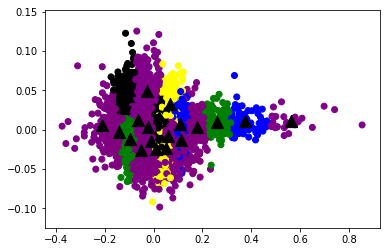

In [110]:
# Cluster Output 
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080","#800081","#800082","#800085","#800087","#000001","#800089",
         "#FFFF00", "#008000", "#0000FF", "#800080","#800081","#800082","#800085","#800087","#000001","#800089"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [111]:
len(labels)

5919

In [113]:
labels = pd.DataFrame(labels)

/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,0,Address
0,11,crisil house 46 near pf office
1,6,97
2,18,mettl 85 gf opposite hsbc bank
3,18,chimes 142 142 near luminous
4,0,48 limeroad


In [363]:
labels.to_csv("Addrsss_20.csv")

In [378]:
#---------------------------------------Running Doc2vec on the remaining address-------------------------------------------#

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content = []
texts = []
j=0
k=0
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
for em in addressField['without_Numeric_Part']:            
    # add tokens to list
    all_content.append(LabeledSentence1(em,[j]))
    j+=1
    k+=1
print("Number of Address processed: ", k)
print("Number of non-empty Address vectors: ", j)

Number of Address processed:  5919
Number of non-empty Address vectors:  5919


In [379]:
print(all_content[271])

TaggedDocument(phfi  opposite pf office, [271])


In [114]:
d2v_model = Doc2Vec(all_content, size = 2000, window = 10, min_count = 500, workers=7, dm = 1, 
                alpha=0.025, min_alpha=0.001)

d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)


kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=100)  
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()

l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

/home/ubuntu/.venv/lib/python3.5/site-packages/gensim/models/doc2vec.py:579: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if sys.path[0] == '':
/home/ubuntu/.venv/lib/python3.5/si

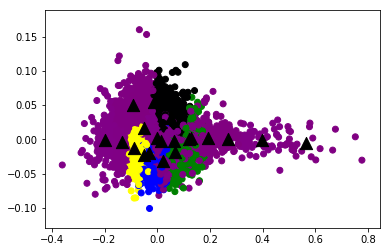

In [31]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080","#800081","#800082","#800085","#800087","#000001","#800089",
         "#FFFF00", "#008000", "#0000FF", "#800080","#800081","#800082","#800085","#800087","#000001","#800089"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [32]:
labels = pd.DataFrame(labels)
labels['Address']= addressField['Clean_Address']

In [383]:
labels.to_csv("without_number_Addrsss_5.csv")

In [ ]:
#################################################################################################################################

In [ ]:
#-----------------------------------------Running NLTK Word Tokenization -----------------------------------------------------#

In [139]:
def strip_address(address):
    address=address.strip()
    return address
addressField['Stripped_Address']= addressField['Clean_Address'].apply(strip_address)

/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
import nltk
nltk.download('punkt') 

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [212]:
addressField['without_Numeric_Part'].head()

0    crisil house  near pf office
1                                
2    mettl  gf opposite hsbc bank
3          chimes   near luminous
4                        limeroad
Name: without_Numeric_Part, dtype: object

In [213]:
# Merging all the addresses into one single paragraph
# The Fields that can be taken are Strpped Address, wihout Numeric Part 
# Removing empty instances
emptyList ='.'.join(addressField['without_Numeric_Part'])


In [298]:
# Creating a function to make sure that there is only one space between the words of the string

def remove_extra_space(address):
    address= re.sub(' +', ' ', address)
    address= re.sub(",",'',address)
    address= re.sub(" ,",'',address)
    address=re.sub(", ",'',address)
    return address


In [671]:
sentList = addressField[['without_Numeric_Part']]
sentList['wordlength'] = sentList['without_Numeric_Part'].apply(len)

# Removing where empty spaces are present 
sentList = sentList[sentList['wordlength']>1]

sentList =sentList[['without_Numeric_Part']]

sentList['without_Numeric_Part'] = sentList['without_Numeric_Part'].apply(remove_extra_space)

print(sentList)

                                   without_Numeric_Part
0                           crisil house near pf office
2                           mettl gf opposite hsbc bank
3                                  chimes near luminous
4                                              limeroad
5                           shopclues near policy bazar
6                               institutional null null
8                                policy bazaar pvt ltd 
9                                  plot o apparel house
10           akhtar ali ssn logistics pvt ltd basement 
12                           tns india private limited 
13              zomato building near by bol petrol pump
14                        near pf office near pf office
15                          delhivery pvt ltd basement 
17    limeroad landmark is opposite the provident fu...
19                    opposite to hsbc bank autoportal 
20                              zomato near petrol pump
21    near apparel house building no institution

/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [672]:
# Tokenizing the individual words of the the without Numeric Part

import string
import re
def tokenize(s) :
    lower_case = s.lower();
    without_punctuation = re.sub(r'[^\w\s]','',lower_case)
    return without_punctuation.split()

tokenized_lines = pd.DataFrame(sentList['without_Numeric_Part'].apply(lambda row: tokenize(row)))
tokenized_lines.reset_index()
tokenized_lines.head(4)

,without_Numeric_Part
0,"[crisil, house, near, pf, office]"
2,"[mettl, gf, opposite, hsbc, bank]"
3,"[chimes, near, luminous]"
4,[limeroad]


In [676]:
sentListall=list(tokenized_lines['without_Numeric_Part'])

In [448]:
# Running word tokenizer on the address set
all_words= [nltk.word_tokenize(sent) for sent in all_sentences]
print(all_words)

TypeError: expected string or bytes-like object

In [328]:
# Creating word2vec representation of the words
# windows width defines the number of words adjacent to the target word taken for model definition
# min_count specifies the minimum number of occureneces that the target word should have for consideration
from gensim.models import Word2Vec
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


In [329]:
word2vec= Word2Vec(tokenized_lines,window=3, min_count=40, workers=4)
vocabulary = word2vec.wv.vocab  
print(len(vocabulary))

85


In [330]:
im_words = word2vec.wv.most_similar('basement')  
print(im_words)

[('sharma', 0.9986629486083984), ('logistics', 0.9985769987106323), ('vipin', 0.9985153675079346), ('technology', 0.9983976483345032), ('delhivery', 0.9983904361724854), ('pvt', 0.9983291625976562), ('ltd', 0.9982846975326538), ('ssn', 0.9980504512786865), ('ggn', 0.9978863000869751), ('com', 0.9978580474853516)]


/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


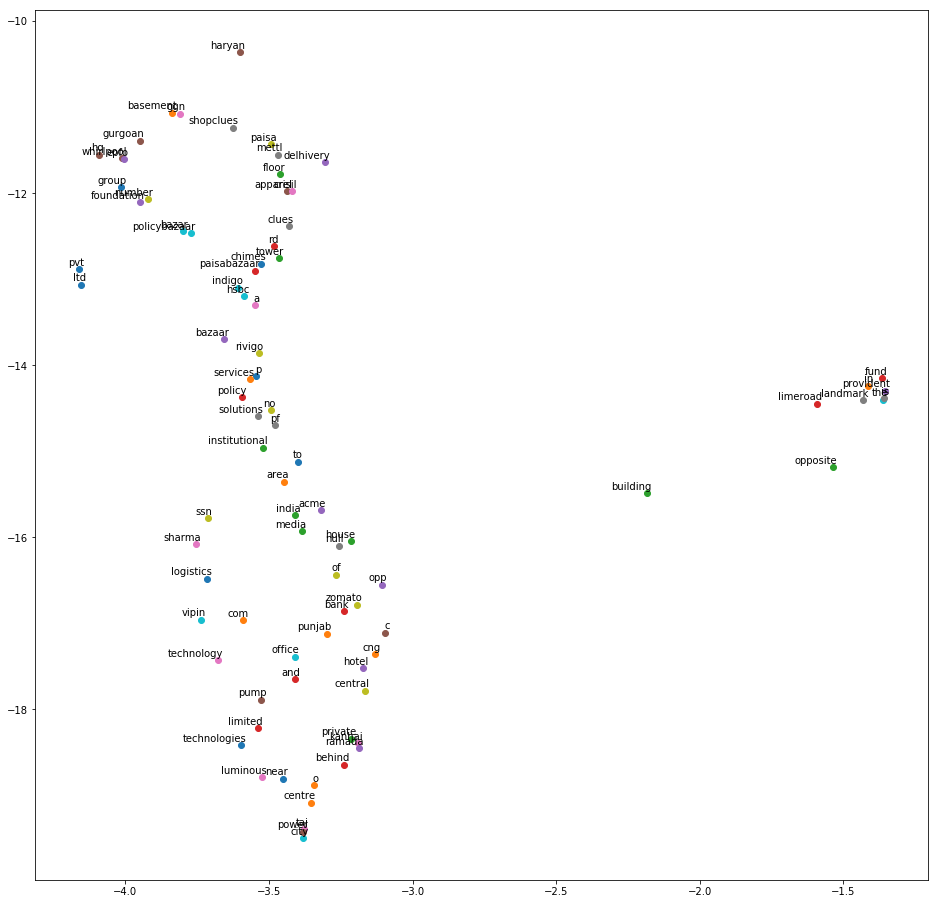

In [332]:
tsne_plot(word2vec)

In [ ]:
#--------------------------------------Creating clusters on sentences(On complete Addresses)-----------------------------------#

In [735]:
sentListall=list(tokenized_lines['without_Numeric_Part'])



In [736]:
# Removing the strings that are empty 
newSentList =[]
for i in sentListall:
    if len(i)>0:
        newSentList.append(i)

In [737]:
print(newSentList)

[['crisil', 'house', 'near', 'pf', 'office'], ['mettl', 'gf', 'opposite', 'hsbc', 'bank'], ['chimes', 'near', 'luminous'], ['limeroad'], ['shopclues', 'near', 'policy', 'bazar'], ['institutional', 'null', 'null'], ['policy', 'bazaar', 'pvt', 'ltd'], ['plot', 'o', 'apparel', 'house'], ['akhtar', 'ali', 'ssn', 'logistics', 'pvt', 'ltd', 'basement'], ['tns', 'india', 'private', 'limited'], ['zomato', 'building', 'near', 'by', 'bol', 'petrol', 'pump'], ['near', 'pf', 'office', 'near', 'pf', 'office'], ['delhivery', 'pvt', 'ltd', 'basement'], ['limeroad', 'landmark', 'is', 'opposite', 'the', 'provident', 'fund', 'building', 'in'], ['opposite', 'to', 'hsbc', 'bank', 'autoportal'], ['zomato', 'near', 'petrol', 'pump'], ['near', 'apparel', 'house', 'building', 'no', 'institutional', 'area'], ['chimes', 'physical', 'therapy', 'clinic'], ['near', 'jk', 'bank', 'near', 'jk', 'bank'], ['shipsy', 'office', 'anu', 'tower'], ['shopclues'], ['near', 'policy', 'bazar'], ['policy', 'bazaar', 'insurance'

In [738]:
from gensim.models import Word2Vec
word2vecSent = Word2Vec(newSentList,min_count=1)
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw

In [739]:
X=[]
for sentence in newSentList:
    X.append(sent_vectorizer(sentence,word2vecSent))   

/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/ubuntu/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [746]:
clusters_number = 11
kclusterer = KMeansClusterer(clusters_number, distance=nltk.cluster.util.cosine_distance,avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X,assign_clusters=True)
print(assigned_clusters)

[4, 9, 4, 6, 4, 4, 7, 4, 7, 4, 1, 4, 10, 6, 9, 4, 1, 4, 4, 4, 4, 4, 4, 2, 7, 7, 4, 8, 0, 10, 5, 10, 8, 10, 3, 6, 9, 6, 6, 4, 10, 4, 4, 3, 3, 4, 4, 6, 10, 10, 8, 5, 6, 7, 6, 10, 4, 4, 3, 7, 4, 4, 4, 9, 5, 4, 7, 4, 10, 4, 10, 4, 4, 10, 10, 9, 7, 7, 4, 5, 10, 4, 4, 10, 9, 4, 5, 5, 10, 10, 4, 4, 8, 7, 10, 10, 8, 10, 4, 4, 4, 4, 8, 6, 6, 8, 4, 10, 4, 3, 5, 4, 1, 4, 7, 4, 4, 10, 10, 4, 6, 3, 10, 1, 4, 8, 4, 4, 4, 10, 10, 3, 4, 4, 4, 1, 4, 6, 4, 10, 4, 6, 10, 4, 10, 4, 5, 4, 4, 10, 4, 5, 4, 10, 10, 2, 4, 10, 4, 5, 4, 10, 4, 4, 3, 4, 9, 10, 4, 5, 4, 4, 4, 4, 0, 9, 1, 3, 4, 10, 7, 5, 4, 10, 5, 7, 10, 8, 4, 2, 4, 4, 10, 4, 8, 4, 6, 2, 10, 8, 6, 7, 5, 3, 2, 4, 8, 4, 4, 4, 4, 10, 8, 7, 4, 5, 9, 10, 10, 6, 4, 3, 4, 1, 4, 4, 4, 4, 4, 4, 3, 10, 6, 0, 5, 10, 5, 5, 10, 8, 1, 6, 10, 1, 9, 4, 4, 4, 1, 4, 4, 6, 6, 10, 4, 4, 4, 1, 4, 10, 10, 10, 7, 4, 8, 10, 4, 1, 7, 4, 4, 4, 7, 8, 4, 8, 4, 1, 3, 10, 2, 7, 10, 10, 6, 4, 4, 8, 4, 4, 10, 4, 5, 6, 4, 5, 8, 2, 4, 8, 4, 8, 2, 4, 7, 4, 3, 10, 8, 4, 10, 4, 4, 4, 

Cluster id labels for inputted data
[15 29 77 ... 46 74 87]
Centroids data
[[-0.03689169  0.08368565  0.08297505 ... -0.01540546 -0.10175802
  -0.06558819]
 [-0.04866016  0.14033744  0.20063015 ... -0.03990672 -0.1624413
  -0.17056066]
 [ 0.03995019 -0.00033208  0.12349015 ... -0.02019582  0.08704136
  -0.1475433 ]
 ...
 [-0.02491169  0.09355238  0.16133272 ... -0.03382954 -0.09035265
  -0.14703186]
 [-0.05376257  0.12179513  0.12384851 ... -0.02895312 -0.15111033
  -0.10049986]
 [-0.04090598  0.11701119  0.16691758 ... -0.03593991 -0.13630162
  -0.13674752]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-5.819619490715371
Silhouette_score: 
0.5183345
4 ['crisil', 'house', 'near', 'pf', 'office']
9 ['mettl', 'gf', 'opposite', 'hsbc', 'bank']
4 ['chimes', 'near', 'luminous']
6 ['limeroad']
4 ['shopclues', 'near', 'policy', 'bazar']
4 ['institutional', 'null', 'null']
7 ['policy', 'bazaar', 'pvt', 'ltd']


4 ['cars']
10 ['delhivery', 'pvt', 'ltd']
10 ['delhivery', 'pvt', 'ltd']
4 ['ds', 'heights', 'near', 'hotel', 'chaupal', 'old', 'delhi', 'road', 'near', 'bsnl', 'exhange']
5 ['near', 'policy', 'bazaar']
4 ['chimes', 'p', 'near', 'punjab', 'and', 'wind', 'bank']
10 ['delhivery', 'pvt', 'ltd', 'hq']
7 ['rivigo', 'services', 'pvt', 'ltd']
4 ['momspresso', 'indo', 'asia', 'house', 'indo', 'asia', 'tours']
1 ['building', 'no', 'paisa', 'bazaar', 'com']
6 ['limeroad', 'landmark', 'is', 'opposite', 'the', 'provident', 'fund', 'building', 'in']
4 ['p', 'encore', 'capital', 'group']
4 ['sector', 'institutional', 'area']
1 ['haryan']
9 ['building', 'no']
10 ['delhivery', 'pvt', 'ltd', 'basement']
10 ['delhivery', 'pvt', 'ltd']
9 ['building', 'no']
8 ['building', 'no', 'tamarind', 'global', 'near', 'bestech', 'building']
4 ['mamaearth', 'lower', 'siddhartha', 'house']
2 ['limeroad', 'floor']
4 ['paisabazaar', 'build']
3 ['p', 'near', 'delhivery']
4 ['chimes', 'iomedia', 'india', 'private', 'limit

3 ['acme', 'clean', 'tech', 'solutions', 'pvt', 'ltd', 'sani', 'mandi']
8 ['mettl', 'near', 'hsbc', 'or', 'soil', 'building']
10 ['delhivery', 'pvt', 'ltd']
5 ['policy', 'bazaar']
1 ['building', 'no', 'paisa', 'bazaar', 'com']
1 ['greenply', 'industries', 'ltd', 'hsbc', 'bank', 'building']
6 ['limeroad', 'landmark', 'is', 'opposite', 'the', 'provident', 'fund', 'building', 'in']
8 ['delhivery', 'hq', 'ggn', 'new', 'address', 'is', 'sector']
3 ['clues', 'network', 'pvt', 'ltd', 'hr', 'delhi', 'ncr', 'ind']
7 ['rivigo', 'service', 'pvt', 'ltd', 'bestech']
9 ['building', 'no']
5 ['paisabazaar', 'com']
4 ['encore', 'capital', 'p', 'behind', 'fortis', 'and', 'taj', 'city', 'center']
1 ['haryan']
4 ['igep', 'delta', 'tower', 'institutional', 'area']
4 ['just', 'funky', 'note', 'saturday', 'office', 'will', 'be', 'closed']
4 ['chimes']
10 ['delhivery', 'pvt', 'ltd']
4 ['allianz', 'worldwide', 'partners', 'ford', 'lmc']
4 ['land', 'mark', 'null']
10 ['delhivery', 'pvt', 'ltd', 'basement']
4 ['

7 ['wazir', 'advisors', 'pvt', 'ltd']
4 ['near', 'cng', 'pump', 'zomato']
2 ['sheldon', 'building']
6 ['sectro']
4 ['bp', 'near', 'cng', 'pump', 'kanahi']
1 ['global', 'energy', 'talent', 'sheldon', 'building', 'near', 'rivigo']
6 ['limeroad', 'landmark', 'is', 'opposite', 'the', 'provident', 'fund', 'building', 'in']
7 ['vipin', 'sharma', 'information', 'technology', 'delhivery', 'com', 'ssn', 'logistics', 'pvt', 'ltd', 'email', 'vipin', 'sharma', 'delhivery', 'com', 'web', 'www', 'delhivery', 'com', 'cell']
8 ['institutional', 'area', 'hsbc', 'building']
7 ['akhtar', 'ali', 'delhivery', 'pvt', 'ltd', 'phone', 'no']
4 ['land', 'mark', 'null']
4 ['zomato', 'media', 'private', 'limited']
1 ['paisabazaar', 'com', 'building', 'no', 'ramada', 'central']
4 ['institutional', 'area']
5 ['policy', 'bazaar', 'policy', 'bazaar']
4 ['fcb', 'ulka', 'chimes', 'near', 'punjab', 'and', 'sind', 'bank']
6 ['limeroad', 'landmark', 'is', 'opposite', 'the', 'provident', 'fund', 'building', 'in']
4 ['polic

4 ['clues', 'network', 'private']
8 ['building', 'no', 'hsbc', 'building', 'land', 'mark', 'null']
4 ['whirlpool', 'india']
4 ['zomato', 'office']
4 ['indian', 'oil', 'petrol', 'pump', 'bpo', 'kanhayi', 'gaaw']
6 ['limeroad', 'landmark', 'is', 'opposite', 'the', 'provident', 'fund', 'building', 'in']
4 ['clues', 'network', 'pvt', 'ltd', 'building', 'no', 'mob']
6 ['limeroad', 'landmark', 'is', 'opposite', 'the', 'provident', 'fund', 'building', 'in']
2 ['srijan', 'techonology', 'building']
3 ['zomato', 'media', 'pvt', 'ltd', 'p', 'behind', 'cng', 'gas', 'pump']
5 ['policybazaar', 'com']
4 ['indigo', 'ifly', 'kanahi', 'beside', 'taj', 'city', 'center']
3 ['jtb', 'india', 'ltd', 'siddhartha', 'house']
0 ['in', 'front', 'of', 'parking', 'stand']
4 ['paisabazaar', 'behind', 'ramada', 'central']
4 ['gng', 'tower', 'bidonhomes', 'com']
1 ['haryan']
4 ['niket', 'sood', 'accor', 'hotels', 'p']
4 ['rj', 'corp', 'institutional', 'area']
8 ['delhivery', 'hq', 'ggn', 'new', 'address', 'is', 'secto

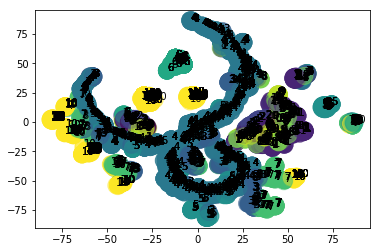

In [749]:
# Defining the Function to Compute Silhoutte Coefficient and Plotting Cluster Data 
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(X)
 
plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
 
for j in range(len(newSentList)):    
   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   print ("%s %s" % (assigned_clusters[j],  newSentList[j]))
 
 
plt.show()